In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
%matplotlib inline


In [25]:

# Load datasets
crop_yield = pd.read_csv(r"C:\Users\admin\Desktop\AI-Driven Smart Crop Water Allocation System using Predictive Analytics\Data\crop_yield.csv")
rainfall = pd.read_csv(r"C:\Users\admin\Desktop\AI-Driven Smart Crop Water Allocation System using Predictive Analytics\Data\rainfall in india 1901-2015.csv")

# Display basic information and first few rows of each dataset
print("Crop Yield Dataset Info:")
print(crop_yield.info())
print(crop_yield.head())

print("\nRainfall Dataset Info:")
print(rainfall.info())
print(rainfall.head())

crop_yield.columns = crop_yield.columns.str.strip().str.lower().str.replace(" ", "_")
rainfall.columns = rainfall.columns.str.strip().str.lower().str.replace(" ", "_")

# Check for missing values
print("\nMissing values in Crop Yield:")
print(crop_yield.isnull().sum())

print("\nMissing values in Rainfall:")
print(rainfall.isnull().sum())

# Drop duplicates if any
crop_yield = crop_yield.drop_duplicates()
rainfall = rainfall.drop_duplicates()

# Display dataset shapes
print("\nCrop Yield Shape:", crop_yield.shape)
print("Rainfall Shape:", rainfall.shape)

# Preview datasets
print("\nCrop Yield Sample:")
print(crop_yield.head())

print("\nRainfall Sample:")
print(rainfall.head())

Crop Yield Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Crop             19689 non-null  object 
 1   Crop_Year        19689 non-null  int64  
 2   Season           19689 non-null  object 
 3   State            19689 non-null  object 
 4   Area             19689 non-null  float64
 5   Production       19689 non-null  int64  
 6   Annual_Rainfall  19689 non-null  float64
 7   Fertilizer       19689 non-null  float64
 8   Pesticide        19689 non-null  float64
 9   Yield            19689 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.5+ MB
None
           Crop  Crop_Year       Season  State     Area  Production  \
0      Arecanut       1997  Whole Year   Assam  73814.0       56708   
1     Arhar/Tur       1997  Kharif       Assam   6637.0        4685   
2   Castor seed       1997  Kharif


Crop Yield Stats:
          crop_year          area    production  annual_rainfall  \
count  19689.000000  1.968900e+04  1.968900e+04     19689.000000   
mean    2009.127584  1.799266e+05  1.643594e+07      1437.755177   
std        6.498099  7.328287e+05  2.630568e+08       816.909589   
min     1997.000000  5.000000e-01  0.000000e+00       301.300000   
25%     2004.000000  1.390000e+03  1.393000e+03       940.700000   
50%     2010.000000  9.317000e+03  1.380400e+04      1247.600000   
75%     2015.000000  7.511200e+04  1.227180e+05      1643.700000   
max     2020.000000  5.080810e+07  6.326000e+09      6552.700000   

         fertilizer     pesticide         yield  
count  1.968900e+04  1.968900e+04  19689.000000  
mean   2.410331e+07  4.884835e+04     79.954009  
std    9.494600e+07  2.132874e+05    878.306193  
min    5.417000e+01  9.000000e-02      0.000000  
25%    1.880146e+05  3.567000e+02      0.600000  
50%    1.234957e+06  2.421900e+03      1.030000  
75%    1.000385e+0

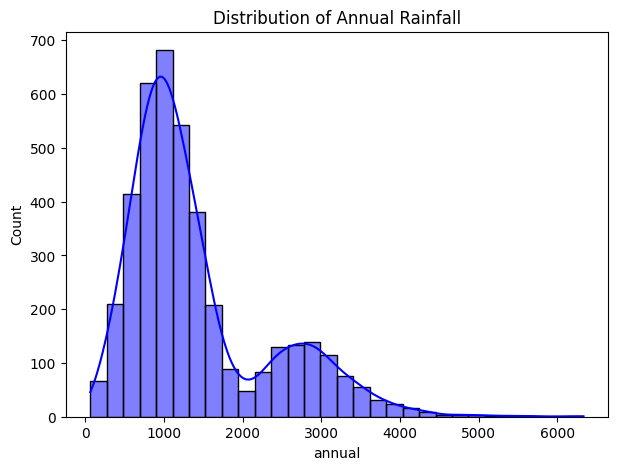

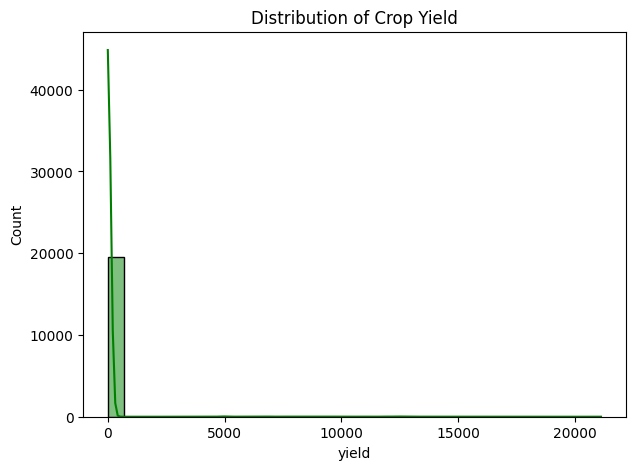

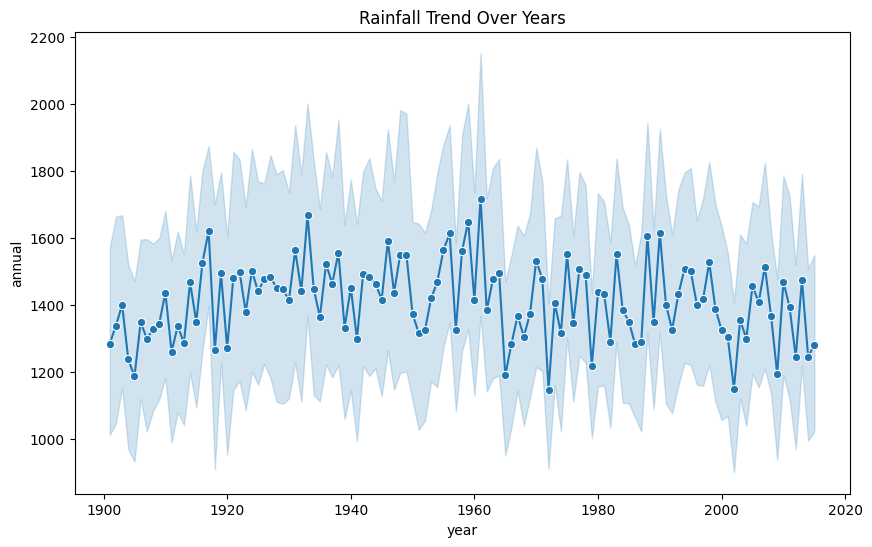

C:\Users\admin\AppData\Local\Temp\ipykernel_10776\3359703333.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.index, y=top_states.values, palette="viridis")


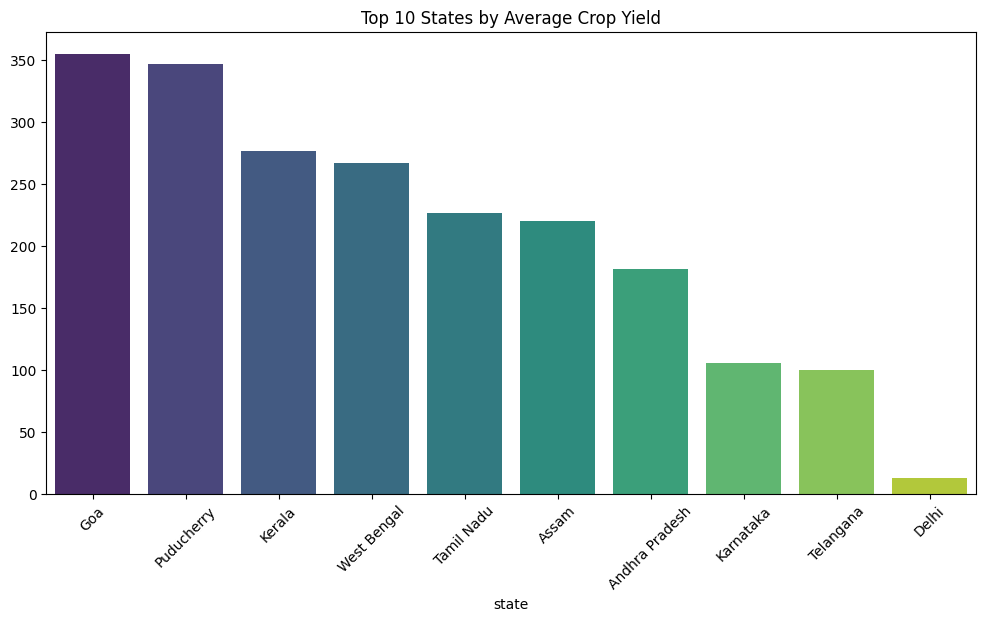

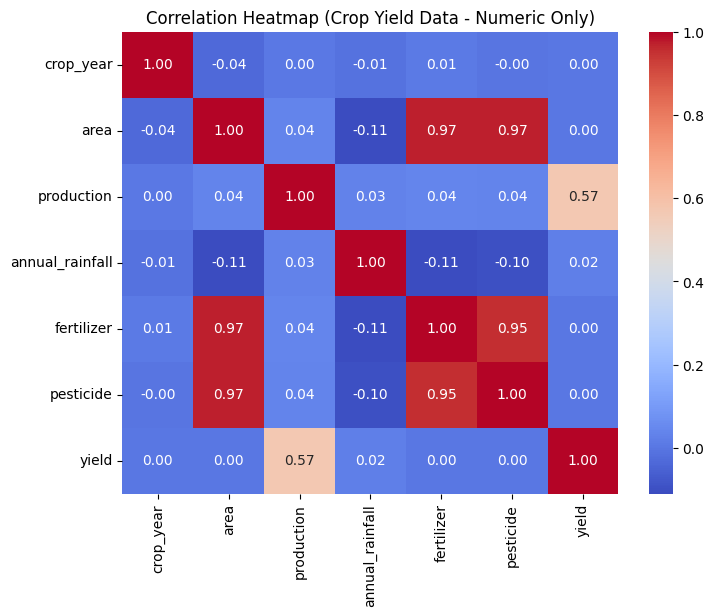

In [26]:
# =====================
# Summary Statistics
# =====================
print("\nCrop Yield Stats:")
print(crop_yield.describe())

print("\nRainfall Stats:")
print(rainfall.describe())

# =====================
# Distribution Plots
# =====================
plt.figure(figsize=(7,5))
sns.histplot(rainfall['annual'], bins=30, kde=True, color='blue')
plt.title("Distribution of Annual Rainfall")
plt.show()

plt.figure(figsize=(7,5))
sns.histplot(crop_yield['yield'], bins=30, kde=True, color='green')
plt.title("Distribution of Crop Yield")
plt.show()


# =====================
# Rainfall Trend Over Years
# =====================
plt.figure(figsize=(10,6))
sns.lineplot(x='year', y='annual', data=rainfall, marker="o")
plt.title("Rainfall Trend Over Years")
plt.show()

# =====================
# Crop Yield by State (Top 10 states)
# =====================
plt.figure(figsize=(12,6))
top_states = crop_yield.groupby("state")["yield"].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_states.index, y=top_states.values, palette="viridis")
plt.title("Top 10 States by Average Crop Yield")
plt.xticks(rotation=45)
plt.show()


# Select only numeric columns
numeric_cols = crop_yield.select_dtypes(include=[np.number])

# Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Crop Yield Data - Numeric Only)")
plt.show()


In [27]:
# ---------------------
# 1. Select useful columns
# ---------------------
crop_yield_clean = crop_yield[["crop_year", "state", "crop", "yield"]].copy()
crop_yield_clean.rename(columns={"crop_year": "year"}, inplace=True)

rainfall_clean = rainfall[["year", "subdivision", "annual"]].copy()
rainfall_clean.rename(columns={"subdivision": "state", "annual": "rainfall"}, inplace=True)

# ---------------------
# 2. Merge datasets
# ---------------------
merged_data = pd.merge(crop_yield_clean, rainfall_clean, on=["year", "state"], how="inner")

print("Merged Data Preview:")
print(merged_data.head())
print("\nShape:", merged_data.shape)


Merged Data Preview:
Empty DataFrame
Columns: [year, state, crop, yield, rainfall]
Index: []

Shape: (0, 5)


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

# =====================
# 1. Load datasets
# =====================
crop_yield = pd.read_csv(r"C:\Users\admin\Desktop\AI-Driven Smart Crop Water Allocation System using Predictive Analytics\Data\crop_yield.csv")
rainfall = pd.read_csv(r"C:\Users\admin\Desktop\AI-Driven Smart Crop Water Allocation System using Predictive Analytics\Data\rainfall in india 1901-2015.csv")

# Standardize column names
crop_yield.columns = crop_yield.columns.str.lower().str.strip()
rainfall.columns = rainfall.columns.str.lower().str.strip()

# =====================
# 2. Select useful columns
# =====================
crop_yield_clean = crop_yield[["crop_year", "crop", "state", "yield"]].copy()
crop_yield_clean.rename(columns={"crop_year": "year"}, inplace=True)

rainfall_clean = rainfall[["year", "annual"]].copy()
rainfall_clean.rename(columns={"annual": "rainfall"}, inplace=True)

# =====================
# 3. Merge datasets
# =====================
merged_data = pd.merge(crop_yield_clean, rainfall_clean, on="year", how="inner")
print("Shape of merged data:", merged_data.shape)
print(merged_data.head())

# =====================
# 4. Handle missing values
# =====================
merged_data = merged_data.dropna(subset=["rainfall", "yield"])
merged_data["rainfall"].fillna(merged_data["rainfall"].mean(), inplace=True)
merged_data["yield"].fillna(merged_data["yield"].mean(), inplace=True)

# =====================
# 5. Define Features (X) and Target (y)
# =====================
X = merged_data[["rainfall"]]   # using rainfall only
y = merged_data["yield"]

# =====================
# 6. Train-Test Split
# =====================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =====================
# 7. Train Model
# =====================
model = LinearRegression()
model.fit(X_train, y_train)

# =====================
# 8. Evaluate Model
# =====================
y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# =====================
# 9. Save Model
# =====================
joblib.dump(model, "water_allocation_model.pkl")
print("✅ Model saved as water_allocation_model.pkl")


Shape of merged data: (554544, 5)
   year      crop  state     yield  rainfall
0  1997  Arecanut  Assam  0.796087    2755.1
1  1997  Arecanut  Assam  0.796087    2274.9
2  1997  Arecanut  Assam  0.796087    2372.2
3  1997  Arecanut  Assam  0.796087    2212.0
4  1997  Arecanut  Assam  0.796087    2551.4
R² Score: -8.046234163394672e-07
MSE: 770351.4684518642
MAE: 153.55705385115283
✅ Model saved as water_allocation_model.pkl


C:\Users\admin\AppData\Local\Temp\ipykernel_10776\1885022476.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["rainfall"].fillna(merged_data["rainfall"].mean(), inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_10776\1885022476.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [29]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

# =====================
# Features & Target
# =====================
X = merged_data[["rainfall"]]
y = merged_data["yield"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =====================
# 1. Random Forest
# =====================
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("🌳 Random Forest R²:", r2_score(y_test, rf_pred))
print("🌳 Random Forest MSE:", mean_squared_error(y_test, rf_pred))
print("🌳 Random Forest MAE:", mean_absolute_error(y_test, rf_pred))

# =====================
# 2. Gradient Boosting
# =====================
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

print("🔥 Gradient Boosting R²:", r2_score(y_test, gb_pred))
print("🔥 Gradient Boosting MSE:", mean_squared_error(y_test, gb_pred))
print("🔥 Gradient Boosting MAE:", mean_absolute_error(y_test, gb_pred))

# =====================
# 3. HistGradientBoosting
# =====================
hgb = HistGradientBoostingRegressor(random_state=42)
hgb.fit(X_train, y_train)
hgb_pred = hgb.predict(X_test)

print("⚡ HistGradientBoosting R²:", r2_score(y_test, hgb_pred))
print("⚡ HistGradientBoosting MSE:", mean_squared_error(y_test, hgb_pred))
print("⚡ HistGradientBoosting MAE:", mean_absolute_error(y_test, hgb_pred))

# =====================
# Pick the best model
# =====================
scores = {
    "RandomForest": r2_score(y_test, rf_pred),
    "GradientBoosting": r2_score(y_test, gb_pred),
    "HistGradientBoosting": r2_score(y_test, hgb_pred)
}

best_model_name = max(scores, key=scores.get)
if best_model_name == "RandomForest":
    best_model = rf
elif best_model_name == "GradientBoosting":
    best_model = gb
else:
    best_model = hgb

# Save best model
joblib.dump(best_model, "best_water_allocation_model.pkl")
print(f"✅ Best model ({best_model_name}) saved as best_water_allocation_model.pkl")


🌳 Random Forest R²: -0.002609461212545794
🌳 Random Forest MSE: 772361.0492690308
🌳 Random Forest MAE: 153.82607384399884
🔥 Gradient Boosting R²: -0.00042903690011808493
🔥 Gradient Boosting MSE: 770681.3575496234
🔥 Gradient Boosting MAE: 153.56632298992662
⚡ HistGradientBoosting R²: -0.00020895871885939776
⚡ HistGradientBoosting MSE: 770511.8201359302
⚡ HistGradientBoosting MAE: 153.50192484290682
✅ Best model (HistGradientBoosting) saved as best_water_allocation_model.pkl


Linear Regression → R²: -0.000, MSE: 770351.468
Random Forest → R²: -0.003, MSE: 772361.049
Gradient Boosting → R²: -0.000, MSE: 770681.358
HistGradientBoosting → R²: -0.000, MSE: 770511.820
✅ Best model saved as excellent_water_allocation_model.pkl


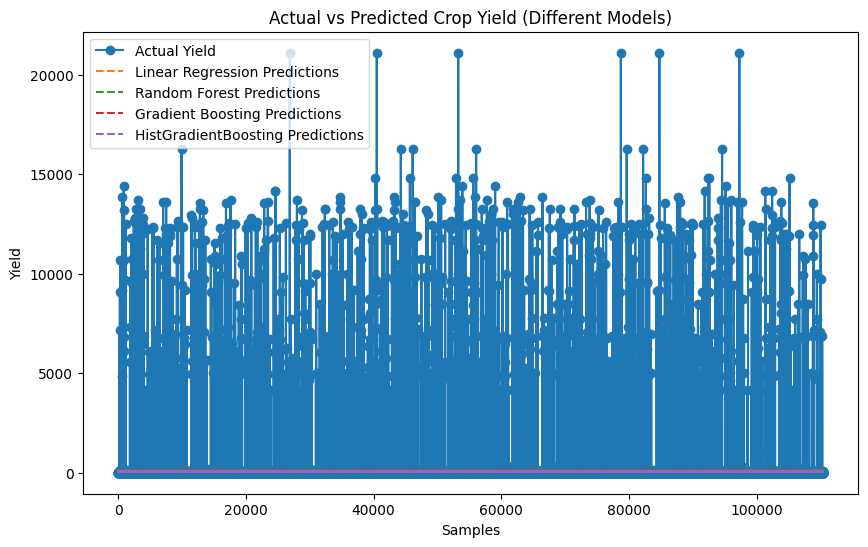

In [31]:
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# =====================
# Train/Test Split
# =====================
X = merged_data[["rainfall"]]
y = merged_data["yield"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =====================
# Models
# =====================
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42)
}

results = {}
best_model = None
best_score = -float("inf")  # start with very low score

# Train & Evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    
    results[name] = {"preds": preds, "r2": r2, "mse": mse}
    print(f"{name} → R²: {r2:.3f}, MSE: {mse:.3f}")

    # Track best model (highest R²)
    if r2 > best_score:
        best_score = r2
        best_model = model

# =====================
# Save the Best Model
# =====================
with open("excellent_water_allocation_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("✅ Best model saved as excellent_water_allocation_model.pkl")

# =====================
# Plot Comparison
# =====================
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual Yield", marker='o')

for name, res in results.items():
    plt.plot(res["preds"], label=f"{name} Predictions", linestyle="--")

plt.title("Actual vs Predicted Crop Yield (Different Models)")
plt.xlabel("Samples")
plt.ylabel("Yield")
plt.legend()
plt.show()
